# 교차 검증과 그리드 서치

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/5-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

## 검증 세트 (Validation Set) vs Trainig Set/Test Set

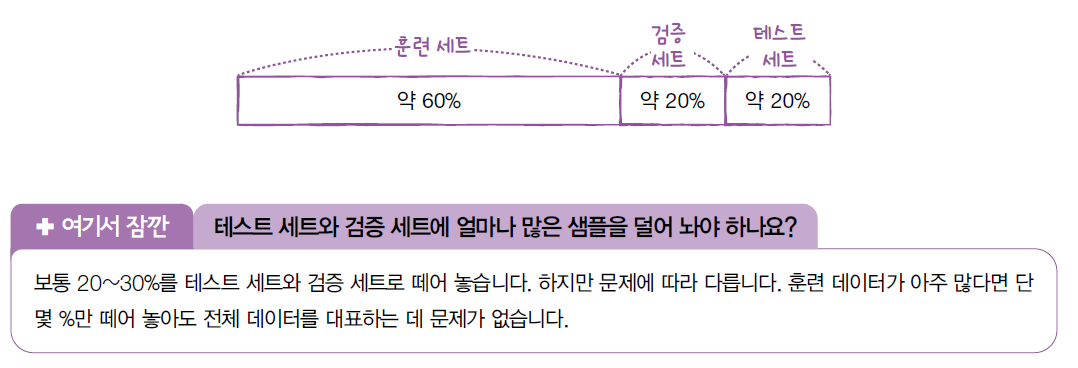

In [12]:
import pandas as pd

In [13]:
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [14]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [17]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [18]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

DecisionTreeClassifier(random_state=42)

In [21]:
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


## 교차 검증 (당장은 Validation Set 사용하지 말자!!!)

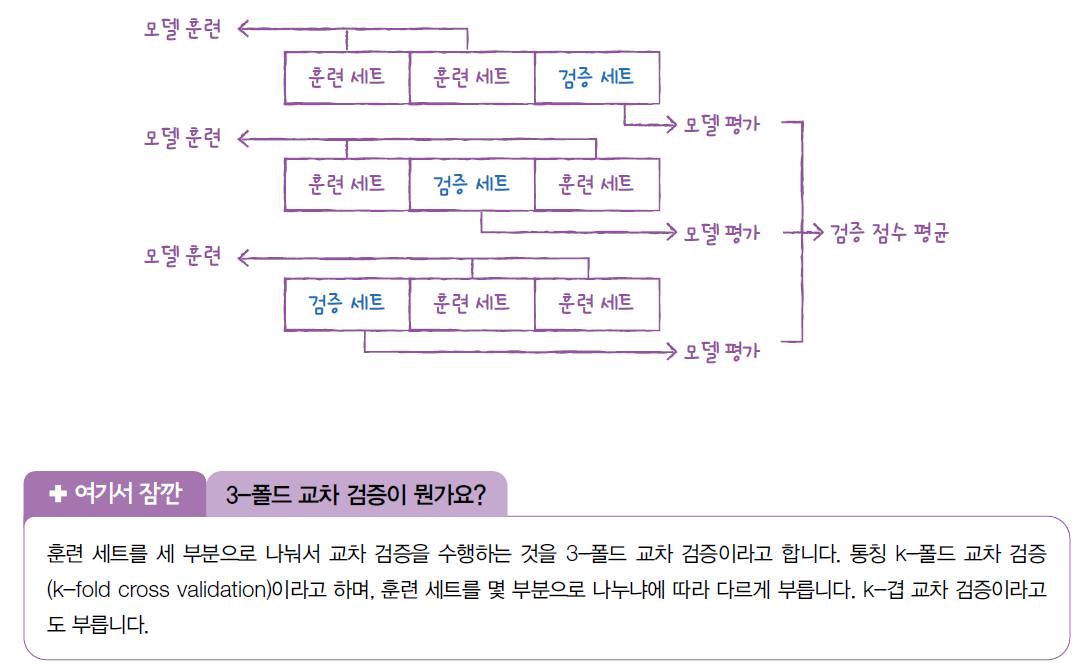

In [22]:
from sklearn.model_selection import cross_validate

In [23]:
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00700521, 0.00694895, 0.00697756, 0.00611329, 0.00598359]), 'score_time': array([0.00100517, 0.00025034, 0.        , 0.        , 0.0010016 ]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [24]:
import numpy as np

In [25]:
print(np.mean(scores['test_score']))

0.855300214703487


In [26]:
from sklearn.model_selection import StratifiedKFold

In [27]:
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [29]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝

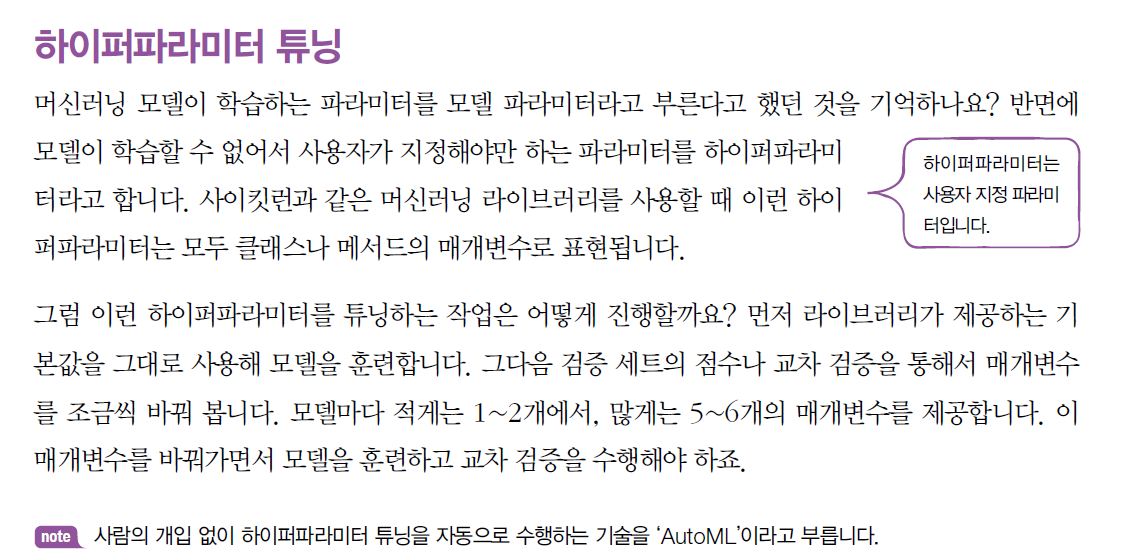

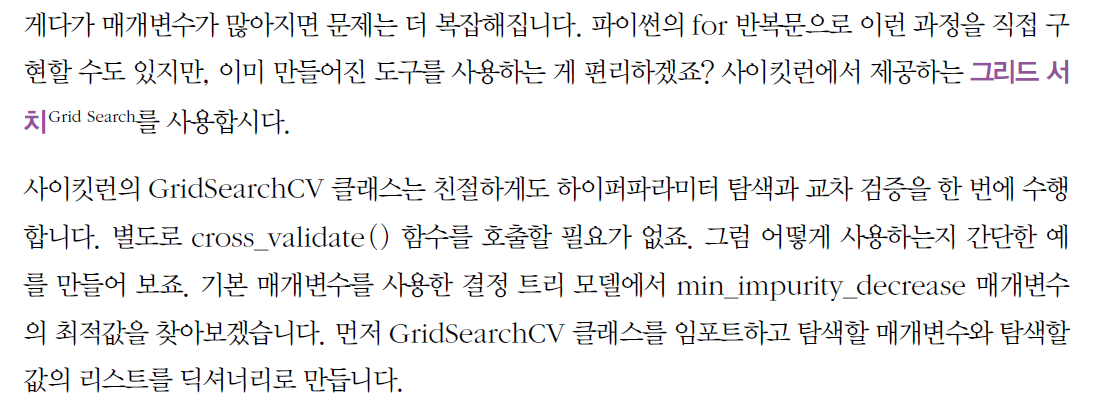

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [35]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [36]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [37]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [38]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [39]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [47]:
# 수동으로 고르는 것보다 넘파이 argmax( ) 함수를 사용하면 가장 큰 값의 인덱스를 추출할 수 있습니다. 
# 그다음 이 인덱스를 사용해 params 키에 저장된 매개변수를 출력할 수 있습니다.
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [48]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

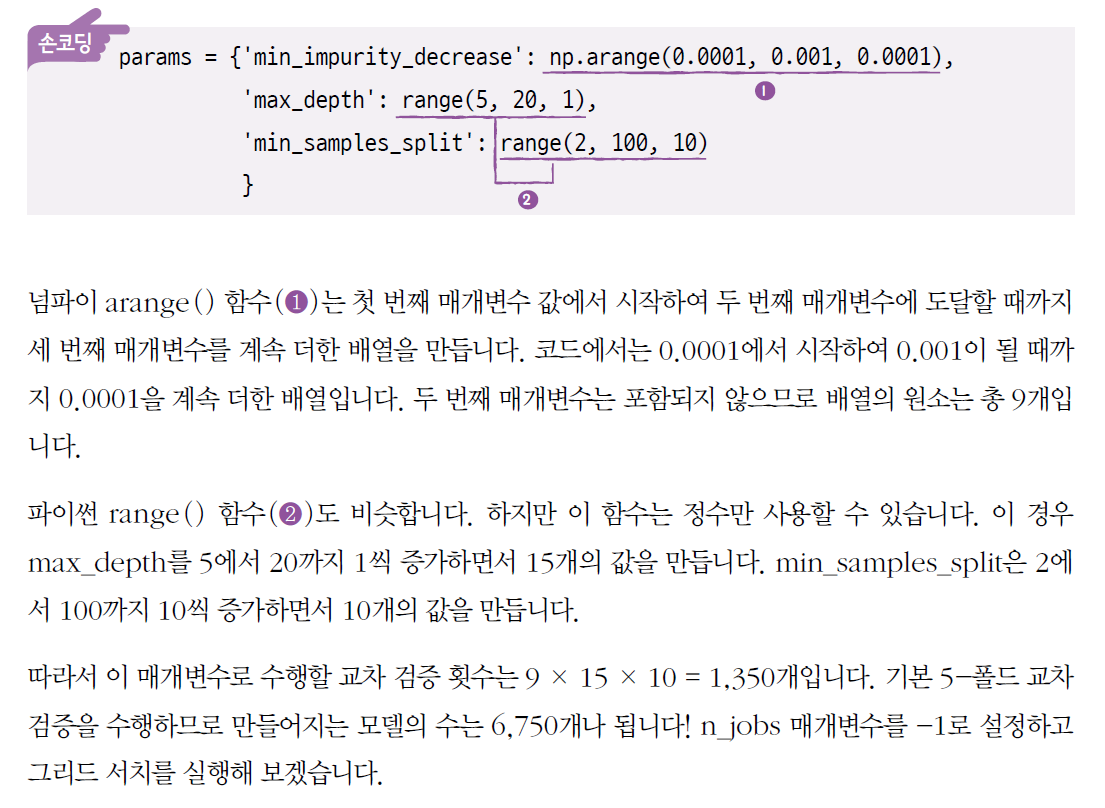

In [53]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [54]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [55]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치 (X : 비추!!!)

In [56]:
from scipy.stats import uniform, randint

In [57]:
rgen = randint(0, 10)
rgen.rvs(10)

array([6, 8, 0, 4, 8, 1, 0, 9, 0, 4])

In [58]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 98, 110,  95, 116,  94,  93, 100,  96, 105,  93], dtype=int64))

In [59]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.89423846, 0.9188809 , 0.68499642, 0.25885915, 0.12213795,
       0.72114165, 0.95524224, 0.33925286, 0.97132318, 0.78802205])

In [60]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [61]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029E1BB02D60>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029E1B6DF5E0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029E1BB02670>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029E1B7D9160>},
                   random_state=42)

In [62]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [63]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [64]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


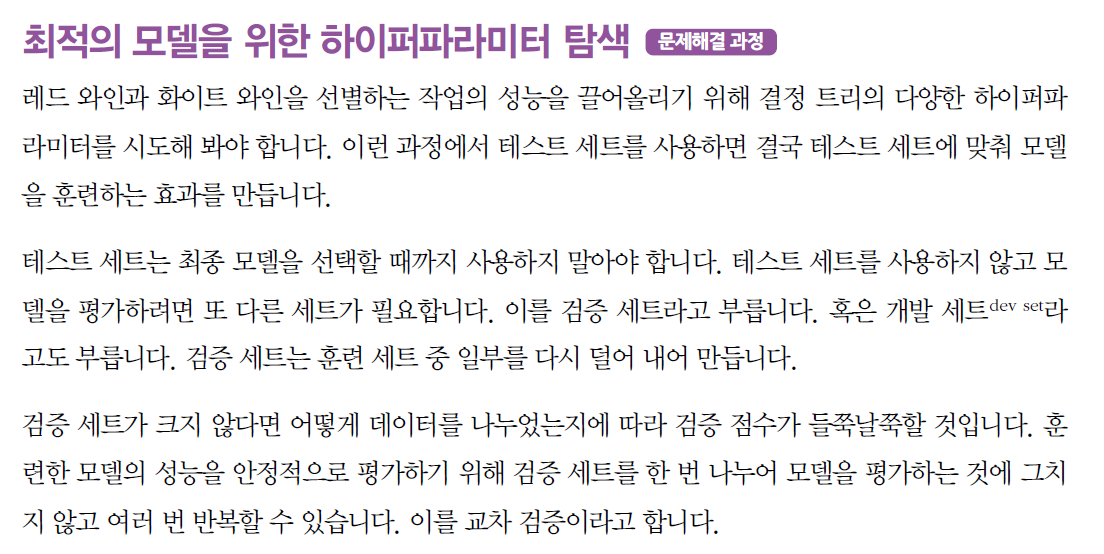

## 확인문제

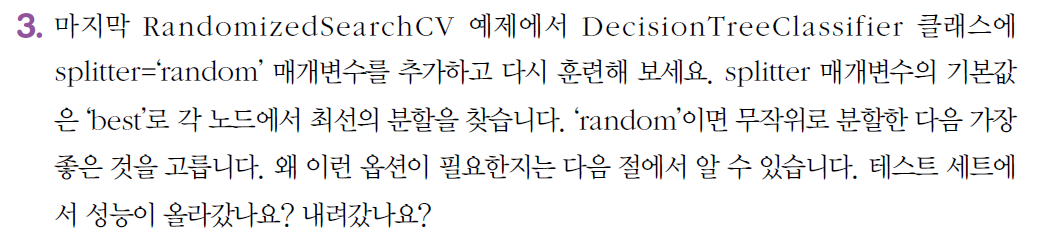

In [67]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029E1BB02D60>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029E1B6DF5E0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029E1BB02670>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029E1B7D9160>},
                   random_state=42)

In [68]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
